In [2]:
import os
import csv
import pandas as pd
import time
import pickle
import sys
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict


In [3]:
print(os.getcwd())
# it should end with this: /AITutor_SeqModeling
# if not, run the next block


/Users/pedram/Projects/GitMyself/AITutor_SeqModeling/KnowledgeTracking


In [4]:
# run if the current directory is not AITutor_SeqModeling
cwd = os.chdir(os.path.join(os.getcwd(), ".."))
print(os.getcwd())

/Users/pedram/Projects/GitMyself/AITutor_SeqModeling


In [5]:
# download the groups as a set
a = pd.read_csv("data/Groups.csv")
valid_ids = set(a["id"].values)
len(valid_ids)

89

In [6]:
File_pickle = "data/KT_logs_annotated.pkl"

# read from pickle
df = pd.read_pickle(File_pickle)

df.head()

,username,skill,correct,time
0,a1,"[Supervised Learning, Classification Algorithms]",True,0.000000
1,a1,"[Supervised Learning, Classification Algorithms]",False,3.726700
2,a2,"[Supervised Learning, Classification Algorithms]",False,0.000000
3,a2,"[Supervised Learning, Classification Algorithms]",True,1.987467
4,a3,"[Supervised Learning, Classification Algorithms]",True,0.000000


In [7]:
# get the number of unique usernames
len(df["username"].unique())

93

In [8]:
# get rid of entries where username is not in the valid_ids
df = df[df["username"].isin(valid_ids)]
len(df["username"].unique())

89

In [9]:
skills = pickle.load(open("data/Skill_hirereachy.pkl", "rb"))

In [9]:
# version 1: Only user params
# user_params = {}

# def initialize_user_params(user_id, skills):
#     user_params[user_id] = {}
#     for skill in skills.keys():
#         skill_params = skills[skill][-1]
#         user_params[user_id][skill] = {
#             "P(L)": skill_params[0],
#             "P(T)": skill_params[1],
#             "P(G)": skill_params[2],
#             "P(S)": skill_params[3]
#         }
# for user_id in df["username"].unique():
#     initialize_user_params(user_id, skills)

In [10]:
# version 2: seperate user-specific and skill specific parameters
def initialize_params(skills, user_ids):
    user_params = defaultdict(dict)
    skill_params = {}
    for skill in skills.keys():
        skill_params[skill] = {
                "P(L)": skills[skill][-1][0],
                "P(T)": skills[skill][-1][1],
                "P(G)": skills[skill][-1][1],
                "P(S)": skills[skill][-1][3]
            }
        for user_id in user_ids:
            # assume all users have the same initial skill level
            # add prior knowledge here if exists
            for skill in skills.keys():
                user_params[user_id][skill] =  {
                    "P(L)": skills[skill][-1][0],
                    "P(T)": skills[skill][-1][1],
                    "P(G)": skills[skill][-1][1],
                    "P(S)": skills[skill][-1][3]
                }
            user_params[user_id]['weight'] = 0.5
    return skill_params, user_params

In [11]:
skill_params, user_params = initialize_params(skills,  df["username"].unique())
user_params['a1']["weight"]

0.5

In [12]:
eps = 1e-9

In [13]:
# Function to compute P(C_t|L_t, G, S)
def compute_prob_correctness(P_L, P_G, P_S, P_T, correct):
    if correct:
        P_L_obs = P_L* (1 - P_S) /((1 - P_S) * P_L + P_G * (1 - P_L))
    else:
        P_L_obs = P_L* (P_S) /(P_S * P_L + (1 - P_G) * (1 - P_L))
    
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    P_C = P_L_new * (1 - P_S) + (1 - P_L_new) * P_G

    # debug
    if not (0 <= P_C <= 1):
        print(f"Invalid P(C): {P_C}, P_L: {P_L}, P_G: {P_G}, P_S: {P_S}, P_T: {P_T}")
    return P_C, P_L_new


In [14]:
def compute_gradients(P_tuple, correct):

    P_L, P_G, P_S, P_T = P_tuple
    if correct:
        dP_L_obs_dP_L = (1 - P_S) * ((1 - P_S) - P_G) / (((1 - P_S) * P_L + P_G * (1 - P_L)) ** 2)
    else:
        dP_L_obs_dP_L = P_S * (P_S - (1 - P_G)) / ((P_S * P_L + (1 - P_G) * (1 - P_L)) ** 2)

    P_L_obs = P_L * P_S / (P_S * P_L + (1 - P_G) * (1 - P_L))
    P_L_new = P_L_obs + (1 - P_L_obs) * P_T
    
    
    dP_L_new_dP_L = dP_L_obs_dP_L * (1 - P_T)
    dP_C_dP_L = dP_L_new_dP_L * (1 - P_S) - dP_L_new_dP_L * P_G

    dP_L_new_dP_T = 1 - (P_L_obs if correct else 0)
    dP_C_dP_T = dP_L_new_dP_T * (1 - P_S) - dP_L_new_dP_T * P_G

    dP_C_dP_G = (1 - P_L_new) - P_L_new
    dP_C_dP_S = -P_L_new + P_G * (1 - P_L_new)

    return dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S

In [15]:
def log_likelihood(interaction_log, skill_params, user_params):
    log_likelihood = 0
    expectations = []
    skill_counts = defaultdict(int)
    user_counts = defaultdict(int)
    for _, row in interaction_log.iterrows():
        user_id = row["username"]
        skill_list = row["skill"]
        correctness = row["correct"]

        for skill in skill_list:
            P_L_user = user_params[user_id][skill]["P(L)"]
            P_G_user = user_params[user_id][skill]["P(G)"]
            P_S_user = user_params[user_id][skill]["P(S)"]
            P_T_user = user_params[user_id][skill]["P(T)"]

            P_L_skill = skill_params[skill]["P(L)"]
            P_G_skill = skill_params[skill]["P(G)"]
            P_S_skill = skill_params[skill]["P(S)"]
            P_T_skill = skill_params[skill]["P(T)"]

            
            weight = user_params[user_id]['weight']

            P_L = weight * P_L_user + (1 - weight) * P_L_skill
            P_G = weight * P_G_user + (1 - weight) * P_G_skill
            P_S = weight * P_S_user + (1 - weight) * P_S_skill
            P_T = weight * P_T_user + (1 - weight) * P_T_skill

            # update skill and user counts
            skill_counts[skill] += 1
            user_counts[user_id] += 1

            prob, _ = compute_prob_correctness(P_L, P_G, P_S, P_T, correctness)
            log_likelihood += np.log(prob + eps)
            expectations.append((user_id, skill, prob, correctness, (P_L, P_G, P_S, P_T)))

    return -log_likelihood, expectations, skill_counts, user_counts

In [16]:
def expectation_step(interaction_log, skill_params, user_params):
    skill_grads = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    user_grads = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    weight_grads = {user_id: 0 for user_id in user_params.keys()}
    loss = 0
    log = {}
    log["skill"] = defaultdict(list)
    log["user"] = defaultdict(list)
    # TODO: it goes over all the intraction with the fixed parameters while these parameters can be changed during intractions
    likelihood, expectations, skill_counts, user_counts = log_likelihood(interaction_log, skill_params, user_params)
    if np.isnan(likelihood):
        print("Log-likelihood NaN detected! Check parameter updates.")

    for user_id, skill, prob, correctness,  P_tuple  in expectations:
        log["skill"][skill].append(prob)
        log["user"][user_id].append(prob)
        dP_C_dP_L, dP_C_dP_T, dP_C_dP_G, dP_C_dP_S = compute_gradients(P_tuple, correctness)
        grad = (correctness - prob) / (prob + eps)
        loss += (correctness - prob) ** 2

        # Update user-specific gradients
        w = user_params[user_id]['weight']
        normalizing_factor = user_counts[user_id]/len(skill_counts)
        
        # user_grads[user_id][skill]["P(L)"] += grad * dP_C_dP_L* w / normalizing_factor
        user_grads[user_id][skill]["P(G)"] += grad * dP_C_dP_G* w / normalizing_factor
        user_grads[user_id][skill]["P(S)"] += grad * dP_C_dP_S* w / normalizing_factor
        user_grads[user_id][skill]["P(T)"] += grad * dP_C_dP_T* w / normalizing_factor

        # Update P(L) as a latent variable
        _ , a = compute_prob_correctness(user_params[user_id][skill]["P(L)"],
                                        user_params[user_id][skill]["P(G)"],
                                        user_params[user_id][skill]["P(S)"],
                                        user_params[user_id][skill]["P(T)"], correctness) 
        _ , b = compute_prob_correctness(P_tuple[0],P_tuple[1], P_tuple[2],P_tuple[3],correctness) 
        # a is only the user component while the b is the overal component (both skill and user) 
        user_grads[user_id][skill]["P(L)"] = a                                                                             
        # gradient of weights
        weight_grads[user_id] += grad *( 
            (-user_params[user_id][skill]["P(L)"] + skill_params[skill]["P(L)"]) * dP_C_dP_L + \
                                     (user_params[user_id][skill]["P(T)"] - skill_params[skill]["P(T)"]) * dP_C_dP_T + \
                                    (user_params[user_id][skill]["P(G)"] - skill_params[skill]["P(G)"]) * dP_C_dP_G + \
                                     (user_params[user_id][skill]["P(S)"] - skill_params[skill]["P(S)"]) * dP_C_dP_S)
        

        # Update skill-specific gradients
        normalizing_factor = skill_counts[skill]*user_counts[user_id]
        # skill_grads[skill]["P(L)"] += grad * dP_C_dP_L * (1 - w) / normalizing_factor
        skill_grads[skill]["P(G)"] += grad * dP_C_dP_G * (1 - w)/ normalizing_factor
        skill_grads[skill]["P(S)"] += grad * dP_C_dP_S * (1 - w)/ normalizing_factor
        skill_grads[skill]["P(T)"] += grad * dP_C_dP_T * (1 - w)/ normalizing_factor

        # Update P(L) as a latent variable
        _, skill_grads[skill]["P(L)"] = compute_prob_correctness(skill_params[skill]["P(L)"],
                                                                skill_params[skill]["P(G)"],
                                                                skill_params[skill]["P(S)"],
                                                                skill_params[skill]["P(T)"],
                                                                correctness)
        
    

    return skill_grads, user_grads, weight_grads, likelihood, loss, log

In [17]:
# Parent-Child Constraints
def enforce_constraints(user_params, skill_params, skills):
    for skill, skill_data in skills.items():
        parents = skill_data[1]
        for parent in parents:
            if skill_params[skill]["P(L)"] >= skill_params[parent]["P(L)"]:
                skill_params[skill]["P(L)"] = skill_params[parent]["P(L)"] - 0.01 
            for user in user_params:
                parent_prob = user_params[user][parent]["P(L)"]
                child_prob = user_params[user][skill]["P(L)"]
                if child_prob >= parent_prob:
                    user_params[user][skill]["P(L)"] = parent_prob - 0.01  # Apply heuristic

In [18]:
# Projection
def project_params(params, par_type):
    for key, param_set in params.items():
        if  par_type == "user":
                for skill, ps in param_set.items():
                    if skill == 'weight':
                        params[key][skill] = np.clip(params[key][skill], 0, 1)
                    else:
                        for param in ps:
                            params[key][skill][param] = np.clip(params[key][skill][param], eps, 1-eps)
        elif par_type == "skill":
            for param in param_set:
                params[key][param] = np.clip(params[key][param], eps, 1-eps)
        else:
            raise ValueError("Invalid parameter type. Must be 'user' or 'skill'.")
            
    return params

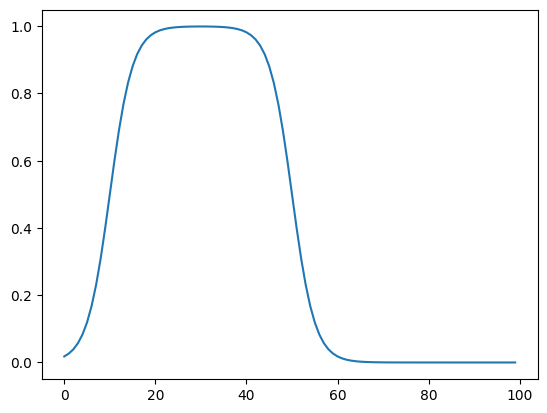

In [19]:
iteration = np.arange(0, 100)
# calculate decay with tanh 
decay = 0.5*(1+( np.tanh(0.2 * (iteration-10)))  -1 * (1+np.tanh(0.2 * (iteration-50))))
plt.plot(iteration, decay)

In [32]:
# M-Step: Update parameters
def maximization_step(skill_params, user_params, skill_grads, user_grads, weight_grads, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1, reg_lambda=0.01, iteration=0):
    # Adam accumulators
    skill_m = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    skill_v = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
    user_m = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    user_v = defaultdict(lambda: defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0}))
    output = defaultdict(list) # for plotting

    decay = 1+0.1*(+np.tanh(0.1 * (iteration-50))-1)
    # Apply batch updates for skill-specific parameters
    for skill, grads in skill_grads.items():
        for param, grad in grads.items():
            # skill_params[skill][param] += learning_rate * grad
            m = skill_m[skill][param]
            v = skill_v[skill][param]

            m = beta1 * m + (1 - beta1) * grad
            v = beta2 * v + (1 - beta2) * (grad ** 2)
            m_hat = m / (1 - beta1 ** t)
            v_hat = v / (1 - beta2 ** t)

            # skill_params[skill][param] = np.clip(skill_params[skill][param] + 10*learning_rate * m_hat / (np.sqrt(v_hat) + epsilon), 0, 1)
            if param == "P(L)":
                skill_params[skill][param] = grad
            else:
                skill_params[skill][param] = np.clip(skill_params[skill][param] +decay*2800*learning_rate * grad , eps, 1-eps)
            skill_m[skill][param] = m
            skill_v[skill][param] = v

    # update with learning rate decay warmpup
    decay = 0.5*(1+( np.tanh(0.2 * (iteration-10)))  -1 * (1+np.tanh(0.2 * (iteration-50))))

    # Apply SGD for user-specific updates
    for user_id, skills in user_grads.items():
        for skill, grads in skills.items():
            for param, grad in grads.items():

                    # user_params[user_id][skill][param] += learning_rate * grad
                    m = user_m[user_id][skill][param]
                    v = user_v[user_id][skill][param]

                    m = beta1 * m + (1 - beta1) * grad
                    v = beta2 * v + (1 - beta2) * (grad ** 2)
                    m_hat = m / (1 - beta1 ** t)
                    v_hat = v / (1 - beta2 ** t)

                    # regulirizer
                    reg = reg_lambda * (skill_params[skill][param]-user_params[user_id][skill][param])
                    if param == "P(L)":
                        user_params[user_id][skill][param] = grad  # update P(L) as a latent variable
                    else:
                        user_params[user_id][skill][param] = np.clip(
                                                user_params[user_id][skill][param] +0.005*learning_rate * (m_hat + reg) / (np.sqrt(v_hat) + epsilon),eps, 1-eps)
                    user_m[user_id][skill][param] = m
                    user_v[user_id][skill][param] = v

    
            
    # Update user weights
    for user_id in user_params.keys():
        user_params[user_id]['weight'] =np.clip(user_params[user_id]['weight'] +decay*0.004*learning_rate * weight_grads[user_id], 0, 1)

    # logging
    output["weight"] = [user_params[user_id]['weight'] for user_id in user_params.keys()]
    output["P(L)"] = [skill_params[skill]["P(L)"] for skill in skill_params.keys()]
    output["PL_user"] = [user_params[list(user_params.keys())[0]][list(skill_params.keys())[2]]["P(L)"], #user 1, skill 3
                         user_params[list(user_params.keys())[5]][list(skill_params.keys())[2]]["P(L)"], #user 6, skill 3
                          user_params[list(user_params.keys())[5]][list(skill_params.keys())[5]]["P(L)"], # user 6, skill 6
                           user_params[list(user_params.keys())[15]][list(skill_params.keys())[7]]["P(L)"] ] # user 16, skill 8

    return skill_params, user_params, output

In [21]:
def run_em_with_sgd(interaction_log, skills, max_iter, learning_rate, reg_lambda):
    skill_params, user_params = initialize_params(skills, interaction_log["username"].unique())
    log =defaultdict(list)
    pt = 0

    for i in range(max_iter):
        log["iteration"].append(i)
        skill_grads, user_grads, weight_grads, likelihood, loss, out_e = expectation_step(interaction_log, skill_params, user_params)
        # decrease the learning rate to half after every 40 iterations
        pt += 1
        if i>10 and pt>5 and loss > log["loss"][-1]:
            pt = 0
            learning_rate *= 0.7
            print(f"Learning rate 30% decreased ")
        skill_params, user_params, out_m = maximization_step(skill_params, user_params, skill_grads, user_grads, weight_grads,learning_rate=learning_rate, reg_lambda = reg_lambda, iteration=i)
        log["weight_avg"].append(np.average(out_m["weight"]))
        log["weight"].append(np.array(out_m["weight"]))
        log["P_L"].append(out_m["P_L"])
        log["P_LU"].append(out_m["PL_user"])
        log["likelihood"].append(likelihood)
        log["loss"].append(loss)
        log["E_skill"].append(out_e["skill"])
        log["E_user"].append(out_e["user"])
        skill_params = project_params(skill_params, "skill")
        user_params = project_params(user_params, "user")
        if i % 5 == 0:
            print(f"Iteration {i + 1}, Log-likelihood: {likelihood}, Loss: {loss}")

    return skill_params, user_params, log

In [22]:
# randomly select 80% of ids for training from  df["username"].unique()
ids = list(df["username"].unique())
np.random.seed(42)
train_ids = np.random.choice(ids, int(0.85*len(ids)), replace=False)
# slect the rest for testing
test_ids = [i for i in ids if i not in train_ids]

# create df for training and testing
train_df = df[df["username"].isin(train_ids)]
test_df = df[df["username"].isin(test_ids)]

Iteration 1, Log-likelihood: 16589.007459267952, Loss: 1940.221905812701
Iteration 6, Log-likelihood: 18599.188487603322, Loss: 1818.7935279221404
Iteration 11, Log-likelihood: 20469.084598838643, Loss: 1669.0759268512024
Iteration 16, Log-likelihood: 21894.850409670285, Loss: 1527.7198843854399
Iteration 21, Log-likelihood: 23073.609932018207, Loss: 1405.0866904861452
Iteration 26, Log-likelihood: 24242.537339669885, Loss: 1291.6586119398817
Iteration 31, Log-likelihood: 25376.94334041181, Loss: 1187.8950089640236
Iteration 36, Log-likelihood: 26496.545624902905, Loss: 1107.1987721084975
Iteration 41, Log-likelihood: 36279.15615286448, Loss: 1043.1567685551477
Iteration 46, Log-likelihood: 48657.24307240491, Loss: 999.1987282038713
Iteration 51, Log-likelihood: 54753.43569688303, Loss: 961.7981713413254
Learning rate 30% decreased 
Iteration 56, Log-likelihood: 58217.485242457245, Loss: 944.8068844556159
Iteration 61, Log-likelihood: 58420.02291166991, Loss: 935.6654645226625
Iteratio

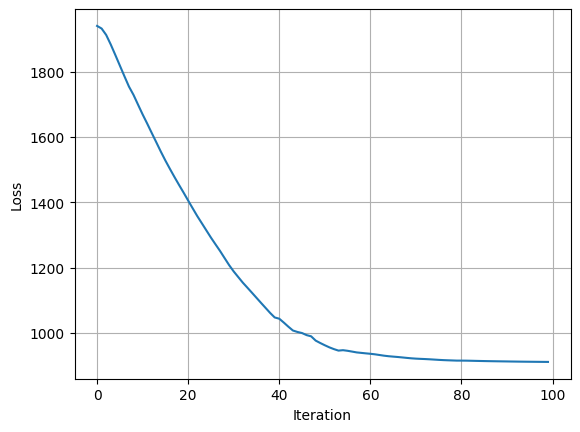

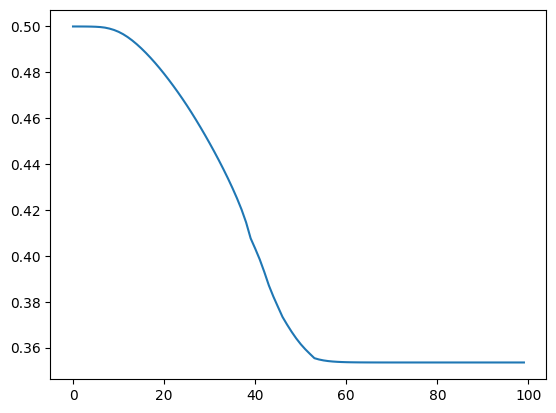

In [31]:
# Run the EM Algorithm
skill_params, user_params, log = run_em_with_sgd(train_df.iloc[:], skills, max_iter=100, learning_rate=5e-3, reg_lambda=0.1 )

# plot the loss of correctness over iteration
plt.figure()
plt.plot(log["iteration"], log["loss"])
plt.grid()
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

# plot average of weights for each epoch
plt.plot(log["iteration"], log["weight_avg"])




Final Skill Parameters:
Data Loading {'P(L)': 0.999999999, 'P(T)': 0.999999999, 'P(G)': 0.9628353968801571, 'P(S)': 0.9248579802170487}
Data Cleaning {'P(L)': 0.4458865003910399, 'P(T)': 0.32294705653332806, 'P(G)': 0.32294705653332806, 'P(S)': 0.21182739966945235}
Handling Missing Data {'P(L)': 1.2511457587369991e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.20080809735605434}
Feature Scaling {'P(L)': 1.0410690398728556e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.03946302973833523}
Exploratory Data Analysis (EDA) {'P(L)': 1.1173288867588947e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.1051156385848793}
Statistical Summaries {'P(L)': 1.3475357912915558e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.25803377770053715}
Visualization {'P(L)': 1.0884722619950354e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.08132823648973016}
Correlation Analysis {'P(L)': 1.0899188303558745e-09, 'P(T)': 1e-09, 'P(G)': 1e-09, 'P(S)': 0.08251779041738685}
Data Splitting {'P(L)': 0.6176354970758771, 'P(T)': 0.56

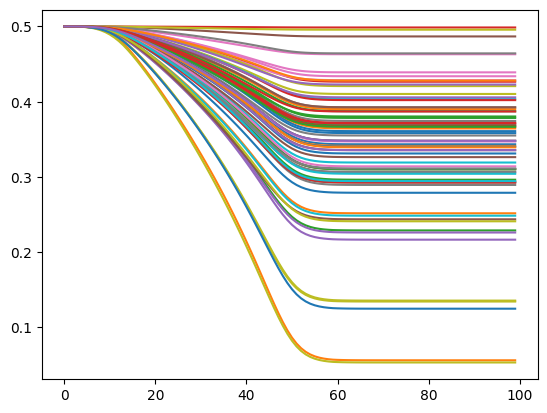

In [191]:
# Output Results
print("Final Skill Parameters:")
for skill, params in skill_params.items():
    print(skill, params)

print("\nFinal User Parameters:")
for user_id, user_data in user_params.items():
    print(user_id)
    for skill, params in user_data.items():
        print(f"  {skill}: {params}")
plt.plot(log["iteration"], log["weight"])

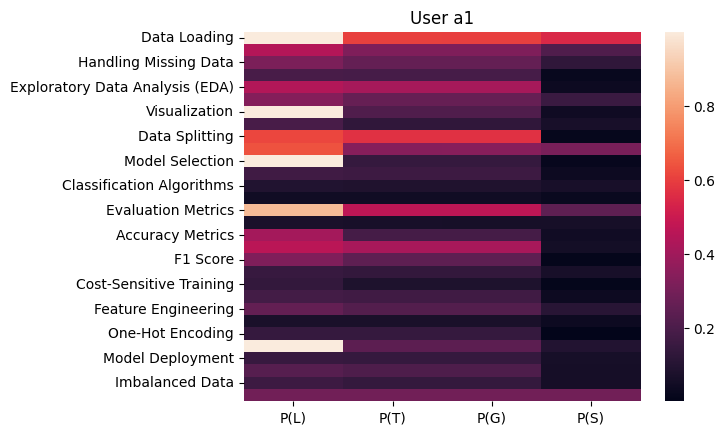

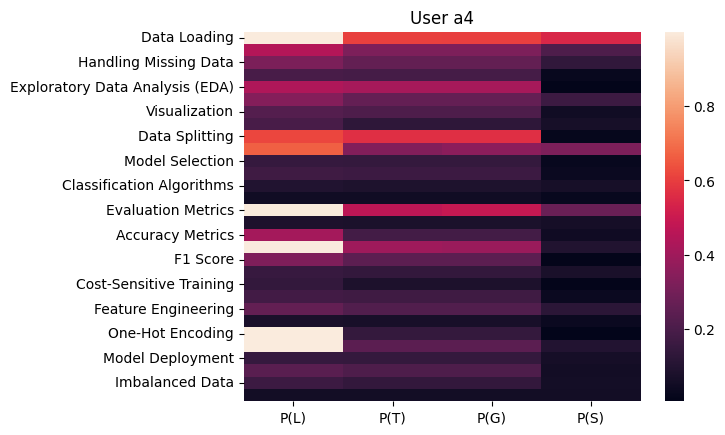

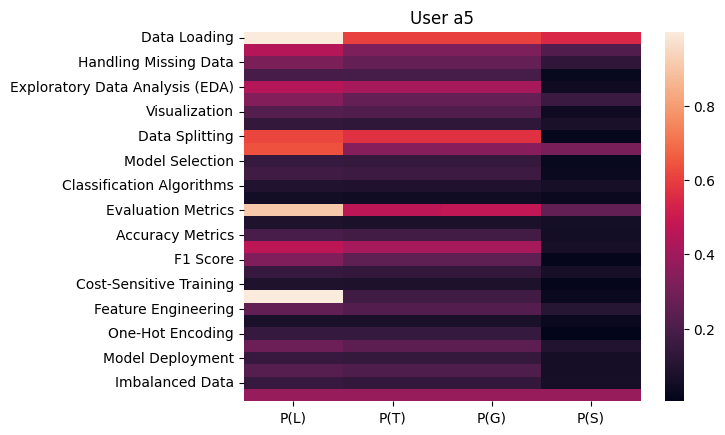

In [243]:
# create heatmap for the first 3 users and compare with skill parameters
for user_id in train_df["username"].unique()[:3]:
    user_data = user_params[user_id]
    user_df = pd.DataFrame(user_data).T
    sns.heatmap(user_df, annot=False)
    plt.title(f"User {user_id}")
    plt.show()


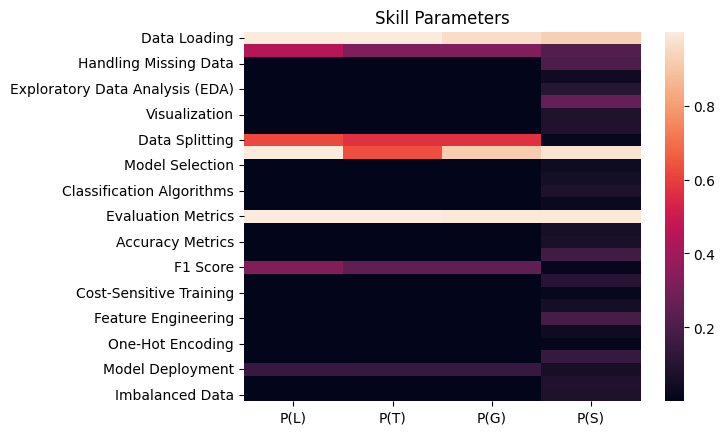

In [244]:
# create heatmap for the skill set parameter
skill_df = pd.DataFrame(skill_params).T
sns.heatmap(skill_df, annot=False)
plt.title("Skill Parameters")
plt.show()

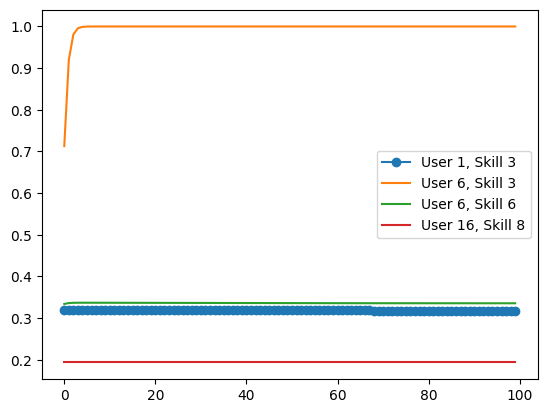

In [245]:
# plot the   first row of the log(P_L) for differnt iteration over interaction
plt.figure()
labels = ['User 1, Skill 3', 'User 6, Skill 3', 'User 6, Skill 6', 'User 16, Skill 8']
for j in range(4):
  y = [log["P_LU"][i][j] for i in range(0,100)]
  if j == 0:
    plt.plot(log["iteration"], y, label=labels[j], marker='o')
  else:
    plt.plot(log["iteration"], y, label=labels[j])
# show the labels
plt.legend()
plt.show()

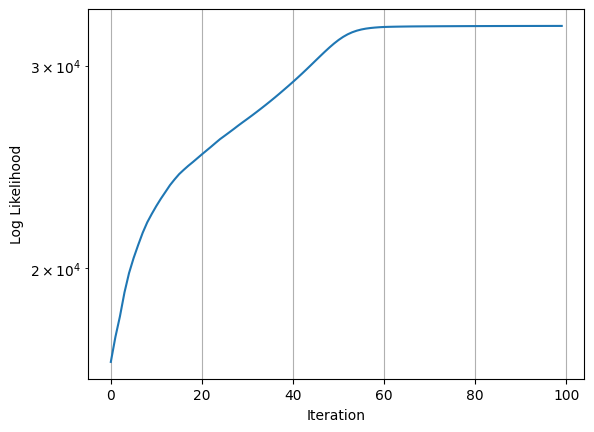

In [246]:
# plot the log likelihood in log scale
plt.figure()
plt.plot(log["iteration"], log["likelihood"])
plt.yscale('log')
plt.grid()
plt.ylabel('Log Likelihood')
plt.xlabel('Iteration')
plt.show()


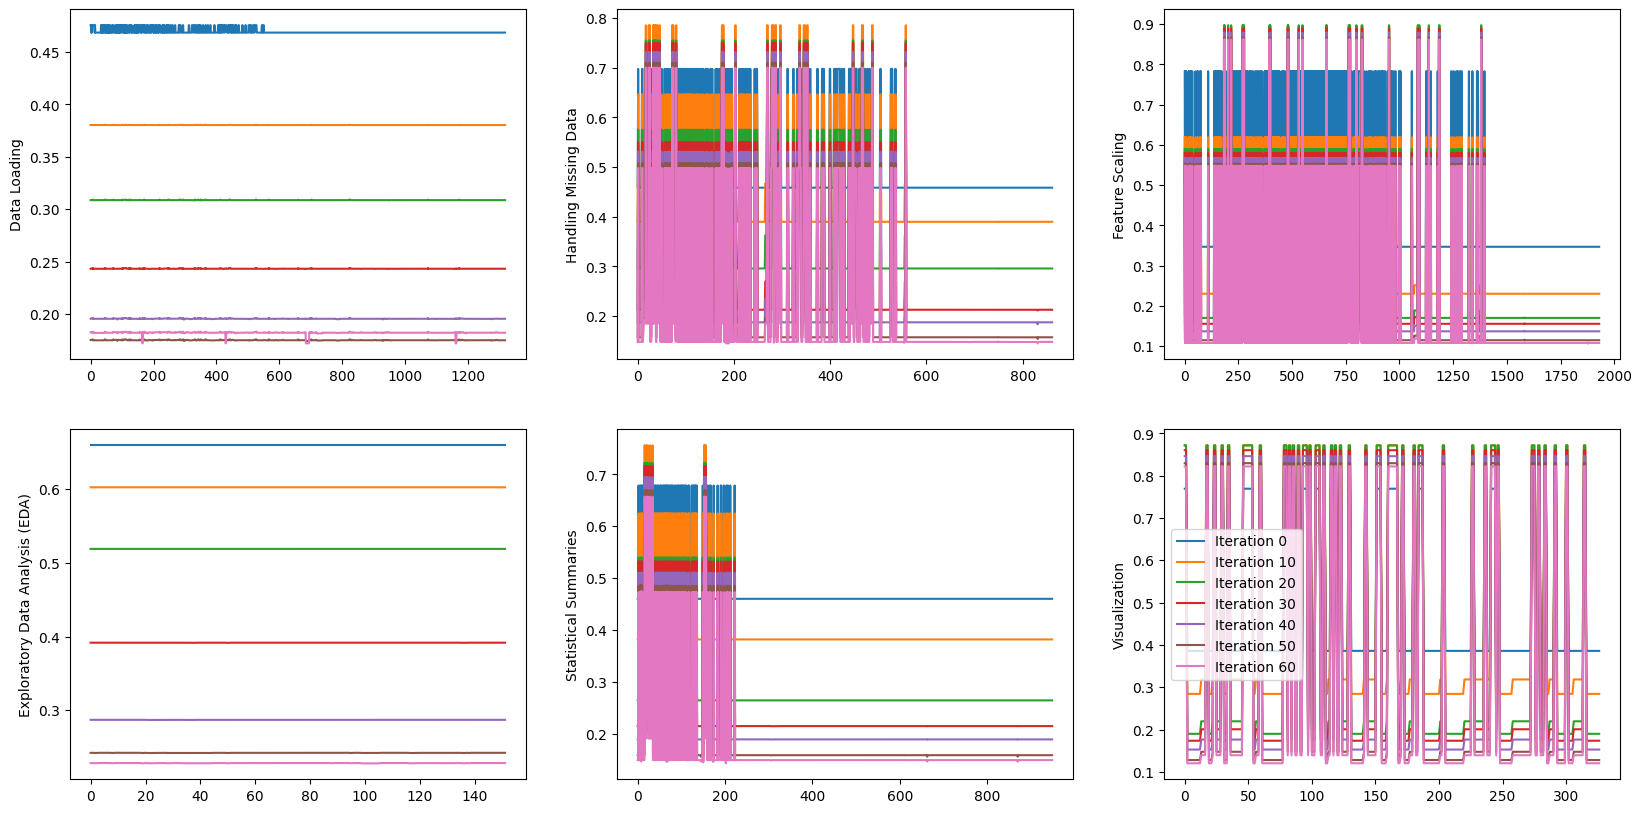

In [247]:
# plot 6 skill over time for different iterations
plt.figure(figsize=(20, 10))
for i in range(0, 70, 10):
    plt.subplot(2, 3, 1)
    skill1 = list(skill_params.keys())[0]
    plt.plot(log["E_skill"][i][skill1])
    plt.ylabel(skill1)
    plt.subplot(2, 3, 2)
    skill2 = list(skill_params.keys())[2]
    plt.plot(log["E_skill"][i][skill2])
    plt.ylabel(skill2)
    plt.subplot(2, 3, 3)
    skill3 = list(skill_params.keys())[3]
    plt.plot( log["E_skill"][i][skill3])
    plt.ylabel(skill3)
    plt.subplot(2, 3, 4)
    skill4 = list(skill_params.keys())[4]
    plt.plot( log["E_skill"][i][skill4])
    plt.ylabel(skill4)
    plt.subplot(2, 3, 5)
    skill5 = list(skill_params.keys())[5]
    plt.plot( log["E_skill"][i][skill5])
    plt.ylabel(skill5)
    plt.subplot(2, 3, 6)
    skill6 = list(skill_params.keys())[6]
    plt.plot( log["E_skill"][i][skill6], label = f"Iteration {i}")
    plt.ylabel(skill6)
plt.legend()
plt.show()

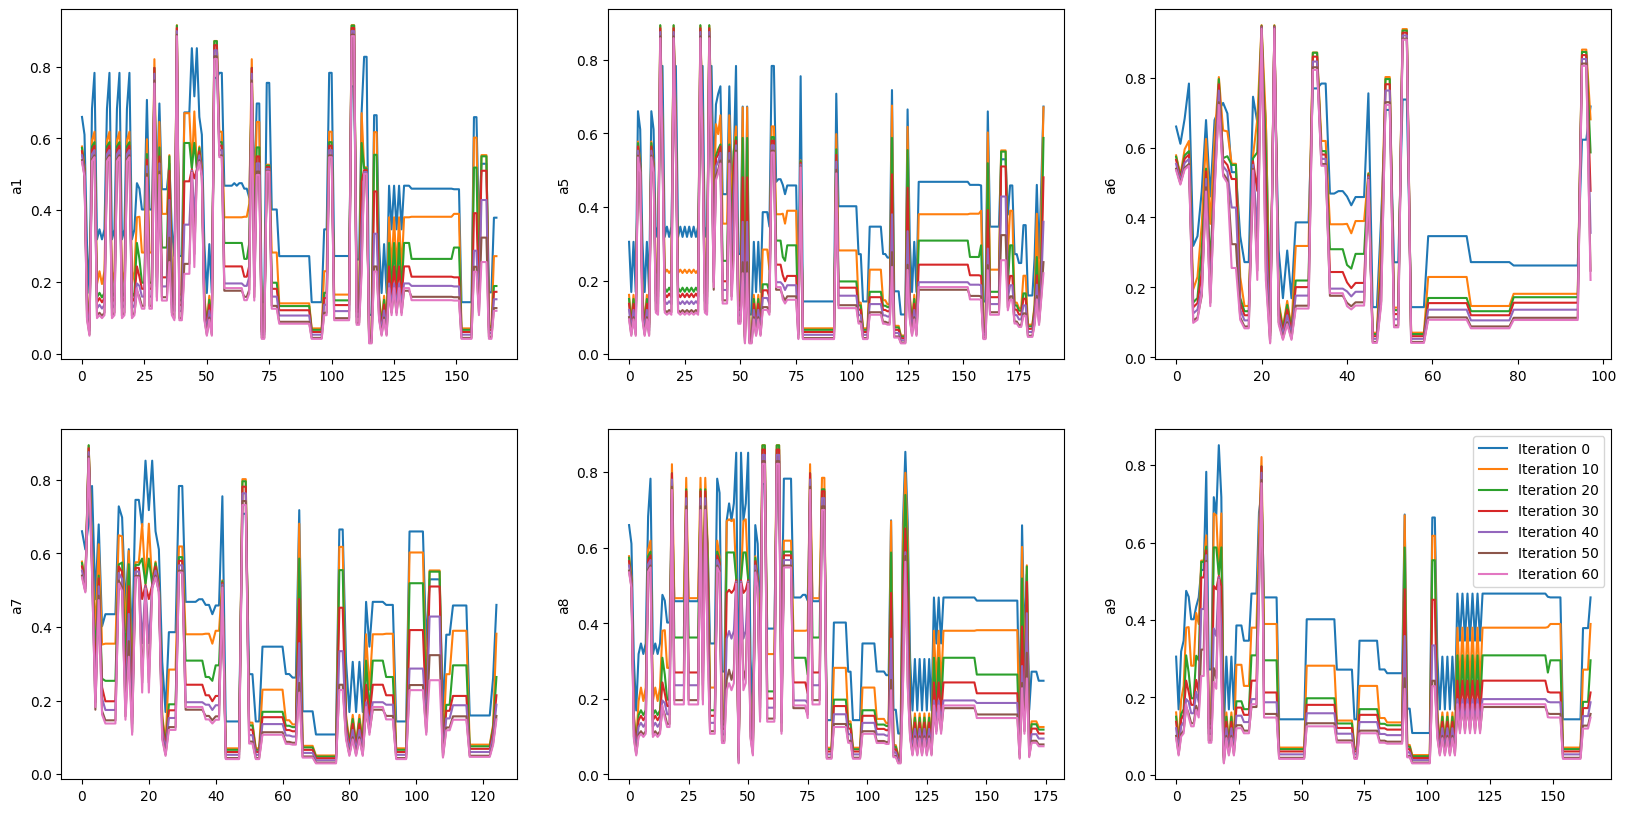

In [248]:
# plot 6 skill over time for different iterations
plt.figure(figsize=(20, 10))
for i in range(0, 70, 10):
    plt.subplot(2, 3, 1)
    user1 = list(user_params.keys())[0]
    plt.plot(log["E_user"][i][user1])
    plt.ylabel(user1)
    plt.subplot(2, 3, 2)
    user2 = list(user_params.keys())[2]
    plt.plot(log["E_user"][i][user2])
    plt.ylabel(user2)
    plt.subplot(2, 3, 3)
    user3 = list(user_params.keys())[3]
    plt.plot( log["E_user"][i][user3])
    plt.ylabel(user3)
    plt.subplot(2, 3, 4)
    user4 = list(user_params.keys())[4]
    plt.plot( log["E_user"][i][user4])
    plt.ylabel(user4)
    plt.subplot(2, 3, 5)
    user5 = list(user_params.keys())[5]
    plt.plot( log["E_user"][i][user5])
    plt.ylabel(user5)
    plt.subplot(2, 3, 6)
    user6 = list(user_params.keys())[6]
    plt.plot( log["E_user"][i][user6], label = f"Iteration {i}")
    plt.ylabel(user6)
plt.legend()
plt.show()

In [208]:
# compute the average of user_params of different users for each skill and parameter
user_param_avg = defaultdict(lambda: {"P(L)": 0, "P(T)": 0, "P(G)": 0, "P(S)": 0})
skill_count = defaultdict(int)
weight_avg, weight_count = 0, 0
for user_id in user_params.keys():
    for skill in user_params[user_id].keys():
        skill_count[skill] += 1
        if skill == 'weight':
            weight_avg += user_params[user_id][skill]
            weight_count += 1
        else:
            for param in user_params[user_id][skill].keys():
                user_param_avg[skill][param] += user_params[user_id][skill][param]

weight_avg = weight_avg/ weight_count
for skill in user_param_avg.keys():
    for param in user_param_avg[skill].keys():
        user_param_avg[skill][param] /= skill_count[skill]

In [226]:
def test_log_likelihood(interaction_log_test, skill_params, user_param_avg, weight):
    log_likelihood = 0
    results = []
    error_skill = defaultdict(float)
    count_skill = defaultdict(int)
    error_user = defaultdict(float)
    count_user = defaultdict(int)
    for _, row in interaction_log_test.iterrows():
        user_id = row["username"]
        skill_list = row["skill"]
        correctness = row["correct"]

        for skill in skill_list:
            P_L_user = user_param_avg[skill]["P(L)"]
            P_G_user = user_param_avg[skill]["P(G)"]
            P_S_user = user_param_avg[skill]["P(S)"]
            P_T_user = user_param_avg[skill]["P(T)"]

            P_L_skill = skill_params[skill]["P(L)"]
            P_G_skill = skill_params[skill]["P(G)"]
            P_S_skill = skill_params[skill]["P(S)"]
            P_T_skill = skill_params[skill]["P(T)"]

            P_L = weight * P_L_user + (1 - weight) * P_L_skill
            P_G = weight * P_G_user + (1 - weight) * P_G_skill
            P_S = weight * P_S_user + (1 - weight) * P_S_skill
            P_T = weight * P_T_user + (1 - weight) * P_T_skill

            prob, P_L_new = compute_prob_correctness(P_L, P_G, P_S, P_T, correctness)
            log_likelihood += np.log(prob + eps)
            results.append((user_id, skill, prob, correctness, P_L_new))
            error_skill[skill] += (correctness - prob) ** 2
            count_skill[skill] += 1
            error_user[user_id] += (correctness - prob) ** 2
            count_user[user_id] += 1
   
    for skill in error_skill.keys():
        error_skill[skill] /= count_skill[skill]

    for user_id in error_user.keys():
        error_user[user_id] /= count_user[user_id]

    return -log_likelihood, results, error_skill, error_user

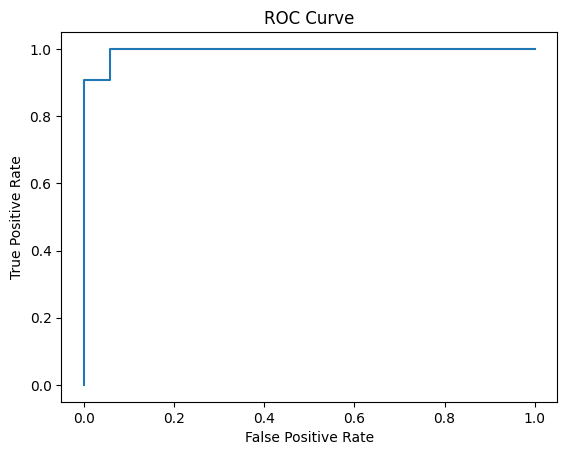

Predicted     0    1
Actual              
False      1948    0
True         87  301
AUC: 0.9946177946188529


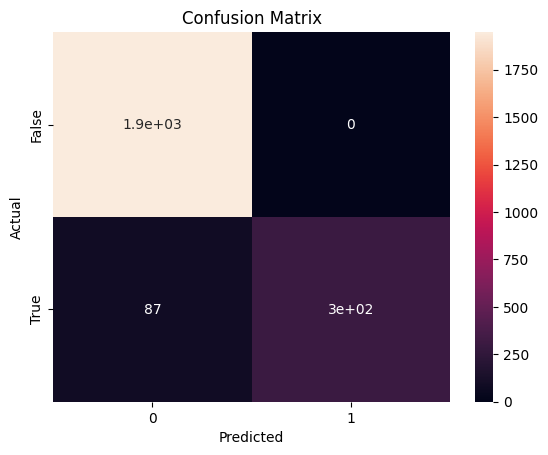

Accuracy: 0.9627568493150684
Precision: 0.7757731958762887
Recall: 1.0
F1 Score: 0.8737300435413644
MSE:  0.050836826013411975


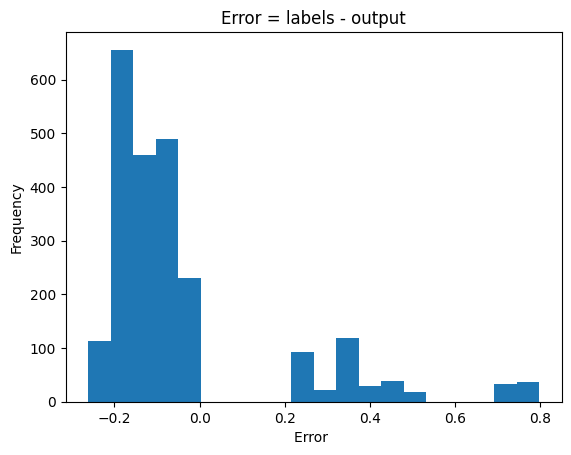

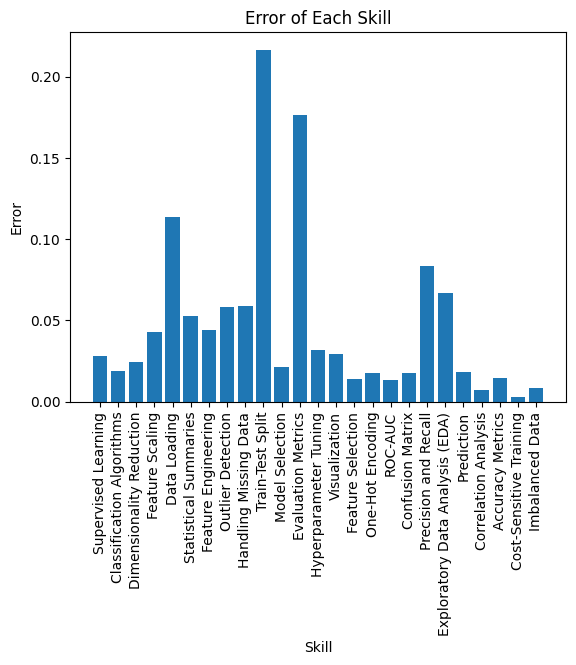

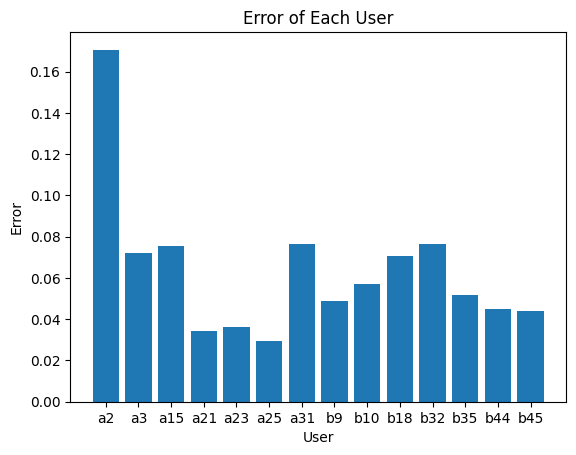

In [242]:
# compute the correctness probability for test cases
from sklearn.metrics import roc_curve, roc_auc_score

test_likelihood, results, error_skill, error_user = test_log_likelihood(test_df, skill_params, user_param_avg, weight_avg)
output = [x[2] for x in results]
labels = [x[3] for x in results]

# create AUROC curve for different theresholds
fpr, tpr, thresholds = roc_curve(labels, output)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# compute the confusion matrix for specific threshold
thresholds = 0.5
predictions = [1 if x > thresholds else 0 for x in output]
confusion_matrix = pd.crosstab(pd.Series(labels, name='Actual'), pd.Series(predictions, name='Predicted'))
print(confusion_matrix)

# compute the AUC score
auc = roc_auc_score(labels, output)
print(f"AUC: {auc}")

# compute the accuracy, F1 score, precision, and recall
TP = confusion_matrix[1][1]
TN = confusion_matrix[0][0]
FP = confusion_matrix[0][1]
FN = confusion_matrix[1][0]

# plot the confusion matrix
sns.heatmap(confusion_matrix, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# plot the histogram of output - labels
error = np.array(labels) - np.array(output)
plt.figure()
plt.hist(error, bins=20)
plt.xlabel('Error ')
plt.ylabel('Frequency')
plt.title('Error = labels - output')


# compute the overal MSE
print("MSE: ", np.mean(np.array(error)**2))

# plot the error of each skill
plt.figure()
plt.bar(error_skill.keys(), error_skill.values())
plt.ylabel('Error')
# rotate the x-axis labels
plt.xticks(rotation=90)
plt.xlabel('Skill')
plt.title('Error of Each Skill')
plt.show()


# plot the error of each user
plt.figure()
plt.bar(error_user.keys(), error_user.values())
plt.ylabel('Error')
# rotate the x-axis labels
plt.xlabel('User')
plt.title('Error of Each User')
plt.show()
